In [1]:
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt 
# numpy (math) libary
import numpy as np

from os import walk

path1 = '../../../data/'

# torch library and sublibraries
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
f = [] # empty list of files
for (dirpath, dirnames, filenames) in walk(path1):
    f.extend(filenames)

# sort list alphabetically
f.sort()
# remove non .ssv files from list
f = [x for x in f if x[-4:]==".ssv"]

In [3]:
print(f[0])

temp = np.loadtxt(path1+f[0])
data = {}

data['x'] = np.copy(temp)[:,3:-1]
data['y_int'] = np.copy(temp)[:,-1]
y = np.zeros((temp.shape[0], 11))
for jj in range(temp.shape[0]):
    y[jj, int(temp[jj,-1])] += 1
data['y'] = np.copy(y)
del y

print('input data x has shape: ',  data['x'].shape)
print('output data y has shape: ', data['y'].shape)
print()

if 0:
    jj = 6
    print(data['x'][jj,:])
    print(data['y'][jj,:])
    print(temp[jj,-1])

full_speach_data.ssv
input data x has shape:  (990, 10)
output data y has shape:  (990, 11)



In [4]:
# normalize data in the range [0,1]
for jj in range(data['x'].shape[1]):
    data['x'][:,jj] = (data['x'][:,jj]-min(data['x'][:,jj]))/(max(data['x'][:,jj])+min(data['x'][:,jj]))

In [5]:
# divide training and test sets
train = {}
test = {}

# The problem is to train the network as well as possible using only
# on data from "speakers" 0-47, and then to test the network on
# speakers 48-89, reporting the number of correct classifications
# in the test set.

# setting '0'
default    = [48*11, 42*11]
# setting '1'

setting = 0
if setting == 0:
    train['x'] = np.copy(data['x'][:default[0],:])
    train['y'] = np.copy(data['y'][:default[0],:])
    train['y_int'] = np.copy(data['y_int'][:default[0]])
    
    test['x']  = np.copy(data['x'][-default[1]:,:])
    test['y']  = np.copy(data['y'][-default[1]:,:])
    test['y_int']  = np.copy(data['y_int'][-default[1]:])
#elif setting == 1:
    
print(train['x'].shape)
print(train['y'].shape)
print()
print(test['x'].shape)
print(test['y'].shape)

(528, 10)
(528, 11)

(462, 10)
(462, 11)


In [6]:
# create x & y torch Variables
x = Variable( torch.from_numpy(train['x']).float() )
y = Variable( torch.from_numpy(train['y']).float() )
y_int = Variable( torch.from_numpy(train['y_int']).long() )
# either input data is float or model becomes doublefloat
# https://stackoverflow.com/questions/44717100/pytorch-convert-floattensor-into-doubletensor?rq=1
# create 
x_test = Variable( torch.from_numpy(test['x']).float() )
y_test = Variable( torch.from_numpy(test['y']).float() )
y_int_test = Variable( torch.from_numpy(test['y_int']).long() )

In [7]:
# define settings for plots
def show_graph(string):
    fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
    ax1 = fig.add_subplot(111)

    error = []
    valid = []
    if string=='loglog':
        for ii, ee in models.items():
            error.append( ax1.loglog(ee[-2][:], label='%s, lr=%1.0e'%(ee[0][0],ee[5][0])) )
            valid.append( ax1.loglog(ee[-1][:], ls='--', c=error[-1][0].get_color(), label='validation error') )
    elif string=='logy':
        for ii, ee in models.items():
            error.append( ax1.semilogy(ee[-2][:], label='%s, lr=%1.0e'%(ee[0][0],ee[5][0])) )
            valid.append( ax1.semilogy(ee[-1][:], ls='--', c=error[-1][0].get_color(), label='validation error') )
    elif string=='logx':
        for ii, ee in models.items():
            error.append( ax1.semilogx(ee[-2][:], label='%s, lr=%1.0e'%(ee[0][0],ee[5][0])) )
            valid.append( ax1.semilogx(ee[-1][:], ls='--', c=error[-1][0].get_color(), label='validation error') )
    else:
        for ii, ee in models.items():
            error.append( ax1.plot(ee[-2][:], label='%s, lr=%1.0e'%(ee[0][0],ee[5][0])) )
            valid.append( ax1.plot(ee[-1][:], ls='--', c=error[-1][0].get_color(), label='validation error') )

    ax1.set_xlabel('iteration number', fontsize = 16)
    ax1.set_ylabel('loss', fontsize = 16)
    title_string = '%d epochs, hidden layers [%d, %d] are width and depth'%(epochs, H, n)
    ax1.set_title(title_string, fontsize = 16)
    legend = ax1.legend(loc='best', fontsize=16)

    plt.show()
    plt.close()

# prints errors in semi-log axis
show_type = 'logy'

# some colors
colors = (('xkcd:orange', 'xkcd:red'),#
          ('xkcd:blue', 'xkcd:purple'),#
          ('xkcd:green', 'xkcd:lime'),#
         )

In [8]:
# define baseline network with relu (clamp)
class Baseline(torch.nn.Module):
    def __init__(self, D_in, H, D_out, n):
        super(Baseline, self).__init__()
        self.linear0 = torch.nn.Linear(D_in, H)
        for jj in range(n):
            exec("self.linear%d = torch.nn.Linear(H, H)" %(jj+1) );
        self.linearOut = torch.nn.Linear(H, D_out)

    def forward(self, x, n, NL_out=False):
        
        h = []
        # sum (linear1) and then relu (clamp)
        h.append( self.linear0(x).clamp(min=0) )
        # sum (linear2) and then relu (clamp)
        for jj in range(n):
            exec("h.append( self.linear%d(h[-1]).clamp(min=0) )" %(jj+1) );
        # sum (out) and the output
        if not NL_out:
            y_pred = self.linearOut(h[-1])
        elif NL_out:
            y_pred = self.linearOut(h[-1]).Softmax()
        else:
            raise ValueError('NL_out must be either True or False, but it isn\'t')
        
        return y_pred # output = y_pred(icted)

In [9]:
# define different network with sigmoid
class BaseSigmoid(torch.nn.Module):
    def __init__(self, D_in, H, D_out, n):
        super(BaseSigmoid, self).__init__()
        self.linear0 = torch.nn.Linear(D_in, H)
        for jj in range(n):
            exec("self.linear%d = torch.nn.Linear(H, H)" %(jj+1) );
        self.linearOut = torch.nn.Linear(H, D_out)

    def forward(self, x, n, NL_out=False):
        h = []
        # sum (linear1) and then sigmoid (F.sigmoid)
        h.append( F.sigmoid(self.linear0(x)) )
        # sum (linear2) and then sigmoid (F.sigmoid)
        for jj in range(n):
            exec("h.append( F.sigmoid(self.linear%d(h[-1]) ) )" %(jj+1) );
        # sum (out) and the output
        if not NL_out :
            y_pred = self.linearOut(h[-1])
        elif NL_out :
            y_pred = F.sigmoid( self.linearOut(h[-1]) )
        else:
            raise ValueError('NL_out must be either True or False, but it isn\'t')
        
        return y_pred # output = y_pred(icted)

In [10]:
# define best fit class 
class BestFitSigmoid(torch.nn.Module):
    def __init__(self, D_in, H, D_out, n):
        super(BestFitSigmoid, self).__init__()
        self.linear0 = torch.nn.Linear(D_in, H)
        for jj in range(n):
            exec("self.linear%d = torch.nn.Linear(H, H)" %(jj+1) );
        self.linearOut = torch.nn.Linear(H, D_out)

    def forward(self, x, n, NL_out=False):
        
        # parameters
        p = [ 689.651615, 0.433819208, 1.31042204, -0.975437185, -0.518489780, 0.403015568, 0.502495627]
        
        #p[0], p[1], p[2], p[3], p[4], p[5], p[6]
        #  a,    b,    c,    d,    g,   x0,   x1)
        #b*sigmoid(a*(arg-x0))+c*relu(arg)+d*relu(arg-x0)+g*relu(arg-x1)
        
        h = []
        h.append( torch.mul( torch.sigmoid( self.linear0(x).add_(-p[5]).mul_(p[0]) ), p[1] ) )
        h[0].add_( self.linear0(x).clamp(min=0).mul_(p[2]) )
        h[0].add_( self.linear0(x).clamp(min=p[5]).mul_(p[3]) )
        h[0].add_( self.linear0(x).clamp(min=p[6]).mul_(p[4]) )
        
        # sum (linear2) and then nonlinear function
        for jj in range(n):
            exec("h.append( torch.mul( torch.sigmoid( self.linear%d(h[-1]).add_(-p[5]).mul_(p[0]) ), p[1] ) )" %(jj+1) );
            exec("h[jj+1].add_( self.linear%d(h[-2]).clamp(min=0).mul_(p[2]) )" %(jj+1) );
            exec("h[jj+1].add_( self.linear%d(h[-2]).clamp(min=p[5]).mul_(p[3]) )" %(jj+1) );
            exec("h[jj+1].add_( self.linear%d(h[-2]).clamp(min=p[6]).mul_(p[4]) )" %(jj+1) );
                     
        # sum (out) and the output
        if not NL_out :
            y_pred = self.linearOut(h[-1])
        elif NL_out:
            y_pred = torch.mul( torch.sigmoid( self.linearOut(h[-1]).add_(-p[5]).mul_(p[0]) ), p[1] )
            y_pred.add_( self.linearOut(h[-1]).clamp(min=0).mul_(p[2]) )
            y_pred.add_( self.linearOut(h[-1]).clamp(min=p[5]).mul_(p[3]) )
            y_pred.add_( self.linearOut(h[-1]).clamp(min=p[6]).mul_(p[4]) )
        else:
            raise ValueError('NL_out must be either True or False, but it isn\'t')
                                
        return y_pred # output = y_pred(icted)

In [11]:
def generate_entry(ii, verbose = False):
    global models
    global LL
                     
    models[ii] = [LL[ii][0],]
    # append model
    if LL[ii][1]=='base':
        models[ii].append( Baseline(D_in, models[ii][0][1], D_out, models[ii][0][2]) )
    elif LL[ii][1]=='sigmoid':
        models[ii].append( BaseSigmoid(D_in, models[ii][0][1], D_out, models[ii][0][2]) )
    elif LL[ii][1]=='bestfit':
        models[ii].append( BestFitSigmoid(D_in, models[ii][0][1], D_out, models[ii][0][2]) )
    else:
        raise ValueError('model type not recognised')
    if verbose:
        print('model:', models[ii][1])
        print('model settings:',D_in, D_out, models[ii][0][1], models[ii][0][2], models[ii][0][3])
    
    # append criterion
    if LL[ii][2]=='MSE':
        models[ii].append( torch.nn.MSELoss(size_average=LL[ii][3][0] ) )
        models[ii].append( LL[ii][3] )
    elif LL[ii][2]=='CEL':
        models[ii].append( torch.nn.CrossEntropyLoss(size_average=LL[ii][3][0] ) )
        models[ii].append( LL[ii][3] )
    else:
        raise ValueError('criterion type not recognised')
        
    if verbose:
        print('criterion:', models[ii][2], '\ncriterion settings:', models[ii][3])
    
    # append optimizer
    if LL[ii][4]=='SGD':
        models[ii].append( torch.optim.SGD(models[ii][1].parameters(), lr=LL[ii][5][0]) )
        models[ii].append( LL[ii][5] )
    #elif ll[4]=='':
    else:
        raise ValueError('optimizer type not recognised')
    
    if verbose:
        print('optimizer:', models[ii][4], '\noptimizer settings:\n', models[ii][5])
    
    # append empty errors list
    models[ii].append( [] )
    models[ii].append( [] )
    print()

def run_training(ii):
    global models
    global x, y, x_test, y_test

    print('epochs\terror\t\tvalidation')
    for t in range(models[ii][0][4]):
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = models[ii][1](x, models[ii][0][2], models[ii][0][3])

        if LL[ii][2]=='MSE':
            # Compute and print loss
            loss = models[ii][2](y_pred, y)
            models[ii][-2].append(loss.data[0])
        
            if (t+1)%(epochs//20) == 0:
                # validation test
                y_pred_valid = models[ii][1](x_test, models[ii][0][2], models[ii][0][3])
                loss_valid = models[ii][2](y_pred_valid, y_test)
                models[ii][-1].append(loss.data[0])
                
                print(t+1, '\t', loss.data[0], '\t', loss_valid.data[0])
                
        elif LL[ii][2]=='CEL':
            # Compute and print loss
            loss = models[ii][2](y_pred, y_int)
            models[ii][-2].append(loss.data[0])
        
            if (t+1)%(epochs//20) == 0:
                # validation test
                y_pred_valid = models[ii][1](x_test, models[ii][0][2], models[ii][0][3])
                loss_valid = models[ii][2](y_pred_valid, y_int_test) #np.argmax( 
                models[ii][-1].append(loss.data[0])
                
                print(t+1, '\t', loss.data[0], '\t', loss_valid.data[0])

        # Zero gradients, perform a backward pass, and update the weights.
        models[ii][4].zero_grad()
        loss.backward()
        models[ii][4].step()

def run_test(ii, verbose=True):
    global models
    global x_test, y_test
                     
    y_pred = models[ii][1](x_test, models[ii][0][2], models[ii][0][3])
    
    correctness = 0
    for jj in range(x_test.shape[0]):
        if y_test.data[jj, np.argmax(y_pred.data[jj,:]) ]:
            correctness += 1
    correctness = correctness/x_test.shape[0]*100
    
    if verbose:
        print('%3.2f'%correctness)

In [12]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N     = train['x'].shape[0]
D_in  = train['x'].shape[1]
H     = 64
D_out = train['y'].shape[1]
n     = 1

epochs = int(10e2)

In [13]:
##### model settings
k = 5e2
base_lr = 1e-4*k
sigm_lr = 1e-6*k
best_lr = 1e-5*k

In [14]:
# settings: '' name, H = width of hidden layers, n = number of hidden H-layers,
#           NL_out = nonlinear output layer/sum-only output layer,
#           'model'
#           'criterion' and parameters
#           'optimizer' and parameters
LL = [[['relu baseline', H, 1, False, epochs],
       'base',
       'MSE', [True],
       'SGD', [base_lr]
      ],
      [['base sigmoid', H, 1, False, epochs],
       'sigmoid',
       'MSE', [True],
       'SGD', [sigm_lr]
      ],
      [['bestfit', H, 1, False, epochs],
       'bestfit',
       'MSE', [True],
       'SGD', [best_lr]
      ],
      [['relu CEL baseline', H, 1, False, epochs],
       'base',
       'CEL', [True],
       'SGD', [base_lr]
      ],
      [['base CEL sigmoid', H, 1, False, epochs],
       'sigmoid',
       'CEL', [True],
       'SGD', [sigm_lr]
      ],
      [['Cel bestfit', H, 1, False, epochs],
       'bestfit',
       'CEL', [True],
       'SGD', [best_lr]
      ],
      [['relu2 baseline', H, 2, False, epochs],
       'base',
       'MSE', [True],
       'SGD', [base_lr]
      ],
      [['base2 sigmoid', H, 2, False, epochs],
       'sigmoid',
       'MSE', [True],
       'SGD', [sigm_lr]
      ],
      [['bestfit2', H, 2, False, epochs],
       'bestfit',
       'MSE', [True],
       'SGD', [best_lr]
      ],
      [['relu CEL baseline2', H, 2, False, epochs],
       'base',
       'CEL', [True],
       'SGD', [base_lr]
      ],
      [['base CEL sigmoid2', H, 2, False, epochs],
       'sigmoid',
       'CEL', [True],
       'SGD', [sigm_lr]
      ],
      [['Cel bestfit2', H, 2, False, epochs],
       'bestfit',
       'CEL', [True],
       'SGD', [best_lr]
      ],
     ]
print(len(LL))

models = {}

12


In [15]:
generate_entry(0, True)
run_training(0)
#show_graph(show_type)
run_test(0)

model: Baseline(
  (linear0): Linear(in_features=10, out_features=64)
  (linear1): Linear(in_features=64, out_features=64)
  (linearOut): Linear(in_features=64, out_features=11)
)
model settings: 10 11 64 1 False
criterion: MSELoss(
) 
criterion settings: [True]
optimizer: <torch.optim.sgd.SGD object at 0x7f059e38b1d0> 
optimizer settings:
 [0.05]

epochs	error		validation
50 	 0.08254338055849075 	 0.08464772999286652
100 	 0.07836109399795532 	 0.08199944347143173
150 	 0.0760759487748146 	 0.08086797595024109
200 	 0.07459400594234467 	 0.08030054718255997
250 	 0.07342401891946793 	 0.07998210191726685
300 	 0.07245080918073654 	 0.07972090691328049
350 	 0.0715361014008522 	 0.07955344766378403
400 	 0.07074403762817383 	 0.07930276542901993
450 	 0.07002834230661392 	 0.07908923178911209
500 	 0.06934705376625061 	 0.07899902760982513
550 	 0.06868107616901398 	 0.07890518009662628
600 	 0.06804805994033813 	 0.07879730314016342
650 	 0.06746555119752884 	 0.07868510484695435
700

In [16]:
generate_entry(1, True)
run_training(1)
#show_graph(show_type)
run_test(1)

model: BaseSigmoid(
  (linear0): Linear(in_features=10, out_features=64)
  (linear1): Linear(in_features=64, out_features=64)
  (linearOut): Linear(in_features=64, out_features=11)
)
model settings: 10 11 64 1 False
criterion: MSELoss(
) 
criterion settings: [True]
optimizer: <torch.optim.sgd.SGD object at 0x7f059e38b0f0> 
optimizer settings:
 [0.0005]

epochs	error		validation
50 	 0.2104809284210205 	 0.21097761392593384
100 	 0.1916986107826233 	 0.19215232133865356
150 	 0.17569884657859802 	 0.17611481249332428
200 	 0.16206246614456177 	 0.16244585812091827
250 	 0.1504369080066681 	 0.150790274143219
300 	 0.14052130281925201 	 0.14084918797016144
350 	 0.13206221163272858 	 0.13236695528030396
400 	 0.12484417855739594 	 0.1251283586025238
450 	 0.11868326365947723 	 0.11894962936639786
500 	 0.11342447251081467 	 0.1136743426322937
550 	 0.10893434286117554 	 0.10917026549577713
600 	 0.1051005944609642 	 0.10532353818416595
650 	 0.10182659327983856 	 0.10203801095485687
700 

model: BestFitSigmoid(
  (linear0): Linear(in_features=10, out_features=64)
  (linear1): Linear(in_features=64, out_features=64)
  (linearOut): Linear(in_features=64, out_features=11)
)
model settings: 10 11 64 1 False
criterion: MSELoss(
) 
criterion settings: [True]
optimizer: <torch.optim.sgd.SGD object at 0x7f059e38b898> 
optimizer settings:
 [0.005]

epochs	error		validation
50 	 0.10462802648544312 	 0.1063213050365448
100 	 0.08937492966651917 	 0.09082447737455368
150 	 0.08672206103801727 	 0.08813963830471039
200 	 0.08580785989761353 	 0.08740963041782379
250 	 0.08535300940275192 	 0.08704184740781784
300 	 0.08494175225496292 	 0.08677556365728378
350 	 0.0845598503947258 	 0.08651804178953171
400 	 0.08424194157123566 	 0.08633214235305786
450 	 0.08393067866563797 	 0.08615566790103912
500 	 0.08363339304924011 	 0.08593779057264328
550 	 0.08332531154155731 	 0.08576030284166336
600 	 0.0830090343952179 	 0.08556709438562393
650 	 0.08266166597604752 	 0.085413329303264

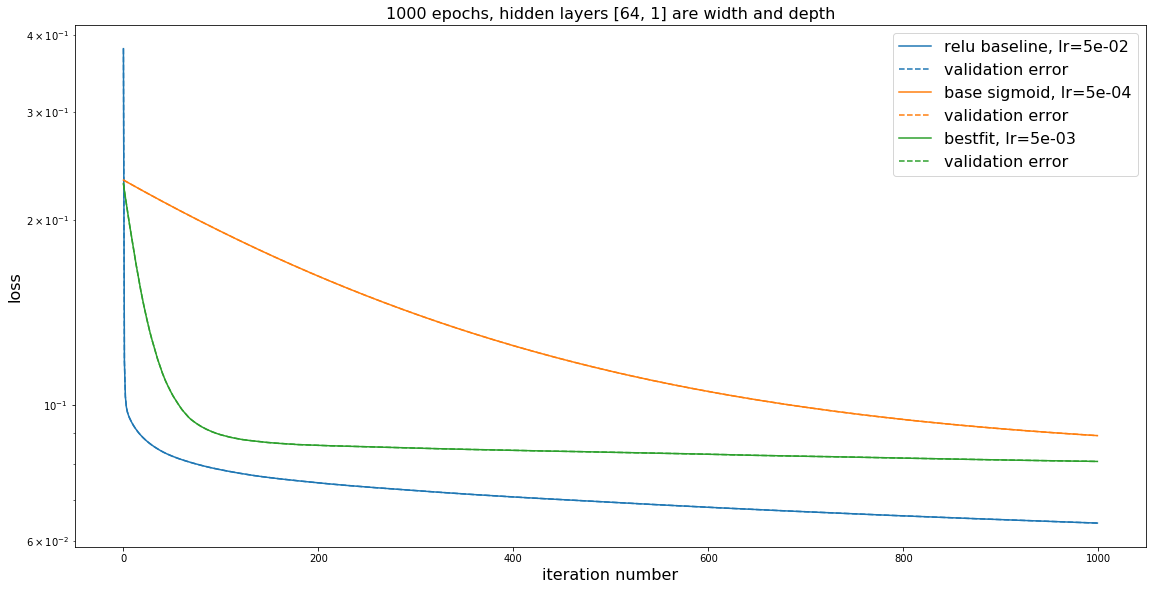

16.67


In [17]:
generate_entry(2, True)
run_training(2)
show_graph(show_type)
run_test(2)

In [18]:
generate_entry(3, True)
run_training(3)
#show_graph(show_type)
run_test(3)

model: Baseline(
  (linear0): Linear(in_features=10, out_features=64)
  (linear1): Linear(in_features=64, out_features=64)
  (linearOut): Linear(in_features=64, out_features=11)
)
model settings: 10 11 64 1 False
criterion: CrossEntropyLoss(
) 
criterion settings: [True]
optimizer: <torch.optim.sgd.SGD object at 0x7f059c65fac8> 
optimizer settings:
 [0.05]

epochs	error		validation
50 	 2.1258814334869385 	 2.2586758136749268
100 	 1.9307154417037964 	 2.196558713912964
150 	 1.9622694253921509 	 2.4559710025787354
200 	 1.7558964490890503 	 2.279426097869873
250 	 1.6538786888122559 	 2.269582986831665
300 	 1.5468908548355103 	 2.247685194015503
350 	 1.4923771619796753 	 2.0993635654449463
400 	 1.4145835638046265 	 2.3142096996307373
450 	 1.2852805852890015 	 2.1243321895599365
500 	 1.1865321397781372 	 2.270251989364624
550 	 1.1047207117080688 	 2.0797743797302246
600 	 1.2232729196548462 	 2.219362258911133
650 	 1.0384835004806519 	 2.3343427181243896
700 	 1.134276032447815 

In [19]:
generate_entry(4, True)
run_training(4)
#show_graph(show_type)
run_test(4)

model: BaseSigmoid(
  (linear0): Linear(in_features=10, out_features=64)
  (linear1): Linear(in_features=64, out_features=64)
  (linearOut): Linear(in_features=64, out_features=11)
)
model settings: 10 11 64 1 False
criterion: CrossEntropyLoss(
) 
criterion settings: [True]
optimizer: <torch.optim.sgd.SGD object at 0x7f059ca6ba20> 
optimizer settings:
 [0.0005]

epochs	error		validation
50 	 2.4258029460906982 	 2.425206422805786
100 	 2.4232218265533447 	 2.4226465225219727
150 	 2.4209001064300537 	 2.4203450679779053
200 	 2.418806552886963 	 2.4182729721069336
250 	 2.416916847229004 	 2.41640043258667
300 	 2.4152042865753174 	 2.4147064685821533
350 	 2.4136569499969482 	 2.4131743907928467
400 	 2.412250518798828 	 2.4117848873138428
450 	 2.410970687866211 	 2.410524368286133
500 	 2.409811019897461 	 2.409376859664917
550 	 2.408752679824829 	 2.408334970474243
600 	 2.407787322998047 	 2.4073853492736816
650 	 2.4069066047668457 	 2.40651798248291
700 	 2.406102418899536 	 2.

In [20]:
generate_entry(5, True)
run_training(5)
#show_graph(show_type)
run_test(5)

model: BestFitSigmoid(
  (linear0): Linear(in_features=10, out_features=64)
  (linear1): Linear(in_features=64, out_features=64)
  (linearOut): Linear(in_features=64, out_features=11)
)
model settings: 10 11 64 1 False
criterion: CrossEntropyLoss(
) 
criterion settings: [True]
optimizer: <torch.optim.sgd.SGD object at 0x7f059cabf710> 
optimizer settings:
 [0.005]

epochs	error		validation
50 	 2.382798910140991 	 2.407944679260254
100 	 2.3594539165496826 	 2.3910634517669678
150 	 2.341599464416504 	 2.3790719509124756
200 	 2.3219711780548096 	 2.372382164001465
250 	 2.3079628944396973 	 2.3645482063293457
300 	 2.289001703262329 	 2.355037212371826
350 	 2.2788007259368896 	 2.3477725982666016
400 	 2.2595622539520264 	 2.3378984928131104
450 	 2.2443482875823975 	 2.330855131149292
500 	 2.2258803844451904 	 2.324009656906128
550 	 2.2043514251708984 	 2.314091205596924
600 	 2.184926986694336 	 2.302208423614502
650 	 2.164257764816284 	 2.2920703887939453
700 	 2.146822690963745

In [21]:
generate_entry(6, True)
run_training(6)
run_test(6)

model: Baseline(
  (linear0): Linear(in_features=10, out_features=64)
  (linear1): Linear(in_features=64, out_features=64)
  (linear2): Linear(in_features=64, out_features=64)
  (linearOut): Linear(in_features=64, out_features=11)
)
model settings: 10 11 64 2 False
criterion: MSELoss(
) 
criterion settings: [True]
optimizer: <torch.optim.sgd.SGD object at 0x7f059c61b0f0> 
optimizer settings:
 [0.05]

epochs	error		validation
50 	 0.08278202265501022 	 0.08326062560081482
100 	 0.08120248466730118 	 0.0822969600558281
150 	 0.07975855469703674 	 0.081477090716362
200 	 0.07870722562074661 	 0.08087839186191559
250 	 0.07784726470708847 	 0.08040279150009155
300 	 0.0771230161190033 	 0.0800919383764267
350 	 0.07651780545711517 	 0.07987867295742035
400 	 0.0759815201163292 	 0.07974608987569809
450 	 0.07548335194587708 	 0.07967967540025711
500 	 0.07505015283823013 	 0.0795748382806778
550 	 0.07465307414531708 	 0.07946598529815674
600 	 0.07427463680505753 	 0.07935716211795807
650

In [22]:
generate_entry(7, True)
run_training(7)
run_test(7)

model: BaseSigmoid(
  (linear0): Linear(in_features=10, out_features=64)
  (linear1): Linear(in_features=64, out_features=64)
  (linear2): Linear(in_features=64, out_features=64)
  (linearOut): Linear(in_features=64, out_features=11)
)
model settings: 10 11 64 2 False
criterion: MSELoss(
) 
criterion settings: [True]
optimizer: <torch.optim.sgd.SGD object at 0x7f059ca6bba8> 
optimizer settings:
 [0.0005]

epochs	error		validation
50 	 0.11966165900230408 	 0.11965769529342651
100 	 0.11406728625297546 	 0.11406324058771133
150 	 0.10931971669197083 	 0.1093159019947052
200 	 0.10529101639986038 	 0.10528668016195297
250 	 0.10187146812677383 	 0.1018672063946724
300 	 0.09896937012672424 	 0.09896476566791534
350 	 0.096505306661129 	 0.09650053083896637
400 	 0.09441444277763367 	 0.09440982341766357
450 	 0.09263946115970612 	 0.09263449907302856
500 	 0.09113308787345886 	 0.09112797677516937
550 	 0.08985432237386703 	 0.0898488387465477
600 	 0.08876864612102509 	 0.08876319229602

In [23]:
generate_entry(8, True)
run_training(8)
run_test(8)

model: BestFitSigmoid(
  (linear0): Linear(in_features=10, out_features=64)
  (linear1): Linear(in_features=64, out_features=64)
  (linear2): Linear(in_features=64, out_features=64)
  (linearOut): Linear(in_features=64, out_features=11)
)
model settings: 10 11 64 2 False
criterion: MSELoss(
) 
criterion settings: [True]
optimizer: <torch.optim.sgd.SGD object at 0x7f059e313780> 
optimizer settings:
 [0.005]

epochs	error		validation
50 	 0.09746024757623672 	 0.09834090620279312
100 	 0.087211973965168 	 0.08873802423477173
150 	 0.0854899138212204 	 0.08744392544031143
200 	 0.0847482681274414 	 0.08661789447069168
250 	 0.08379285037517548 	 0.08607769012451172
300 	 0.0833037942647934 	 0.0859023779630661
350 	 0.08287008106708527 	 0.0858137235045433
400 	 0.08236130326986313 	 0.08569665253162384
450 	 0.08192428946495056 	 0.08580116182565689
500 	 0.0820203647017479 	 0.0862894356250763
550 	 0.08143416792154312 	 0.0857403576374054
600 	 0.08117082715034485 	 0.08573281019926071

In [24]:
generate_entry(9, True)
run_training(9)
run_test(9)

model: Baseline(
  (linear0): Linear(in_features=10, out_features=64)
  (linear1): Linear(in_features=64, out_features=64)
  (linear2): Linear(in_features=64, out_features=64)
  (linearOut): Linear(in_features=64, out_features=11)
)
model settings: 10 11 64 2 False
criterion: CrossEntropyLoss(
) 
criterion settings: [True]
optimizer: <torch.optim.sgd.SGD object at 0x7f059e3130f0> 
optimizer settings:
 [0.05]

epochs	error		validation
50 	 2.2141456604003906 	 2.28963565826416
100 	 2.002821922302246 	 2.228884220123291
150 	 1.9483996629714966 	 2.362227439880371
200 	 1.8473846912384033 	 2.378302812576294
250 	 1.7271956205368042 	 2.3679869174957275
300 	 1.6152466535568237 	 2.3730239868164062
350 	 1.4641621112823486 	 2.1305744647979736
400 	 1.4494190216064453 	 2.255686044692993
450 	 1.3226367235183716 	 2.3769540786743164
500 	 1.1528784036636353 	 2.3473217487335205
550 	 1.1048253774642944 	 2.2839810848236084
600 	 1.047491192817688 	 2.494478464126587
650 	 1.164233326911

In [25]:
generate_entry(10, True)
run_training(10)
run_test(10)

model: BaseSigmoid(
  (linear0): Linear(in_features=10, out_features=64)
  (linear1): Linear(in_features=64, out_features=64)
  (linear2): Linear(in_features=64, out_features=64)
  (linearOut): Linear(in_features=64, out_features=11)
)
model settings: 10 11 64 2 False
criterion: CrossEntropyLoss(
) 
criterion settings: [True]
optimizer: <torch.optim.sgd.SGD object at 0x7f059e313c88> 
optimizer settings:
 [0.0005]

epochs	error		validation
50 	 2.4262351989746094 	 2.426347017288208
100 	 2.4241602420806885 	 2.4242732524871826
150 	 2.4222424030303955 	 2.422356128692627
200 	 2.4204673767089844 	 2.4205832481384277
250 	 2.4188263416290283 	 2.4189422130584717
300 	 2.4173052310943604 	 2.4174227714538574
350 	 2.4158987998962402 	 2.4160172939300537
400 	 2.414594888687134 	 2.4147140979766846
450 	 2.4133872985839844 	 2.4135043621063232
500 	 2.412269115447998 	 2.4123847484588623
550 	 2.4112279415130615 	 2.411346673965454
600 	 2.410264492034912 	 2.410383939743042
650 	 2.40937

In [26]:
generate_entry(11, True)
run_training(11)
run_test(11)

model: BestFitSigmoid(
  (linear0): Linear(in_features=10, out_features=64)
  (linear1): Linear(in_features=64, out_features=64)
  (linear2): Linear(in_features=64, out_features=64)
  (linearOut): Linear(in_features=64, out_features=11)
)
model settings: 10 11 64 2 False
criterion: CrossEntropyLoss(
) 
criterion settings: [True]
optimizer: <torch.optim.sgd.SGD object at 0x7f059cab8320> 
optimizer settings:
 [0.005]

epochs	error		validation
50 	 2.422528028488159 	 2.434711217880249
100 	 2.3908705711364746 	 2.406867265701294
150 	 2.378124237060547 	 2.398648500442505
200 	 2.371652841567993 	 2.396273374557495
250 	 2.3693504333496094 	 2.394339084625244
300 	 2.363903760910034 	 2.3940885066986084
350 	 2.35821533203125 	 2.392162561416626
400 	 2.354458808898926 	 2.390446424484253
450 	 2.3497235774993896 	 2.3903486728668213
500 	 2.344848155975342 	 2.3883674144744873
550 	 2.3379735946655273 	 2.3857011795043945
600 	 2.332470417022705 	 2.382990837097168
650 	 2.3219995498657

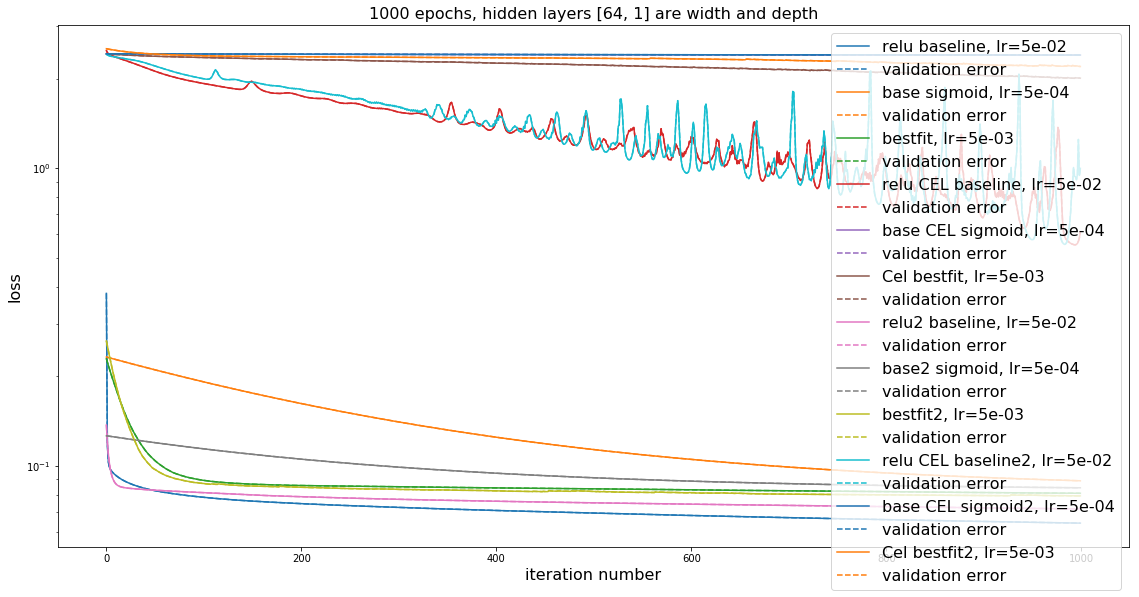

In [27]:
show_graph(show_type)